In [8]:
!pip3 install --upgrade scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


Data shape: (328890, 27)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': 20}
Cross-Validation R² scores: [0.98418678 0.99444963 0.99424237 0.96284729 0.96265813]
Cross-Validation R² mean: 0.979676839485579
Test R²: 0.9746267348177874
Test RMSE: 374.45322446853646


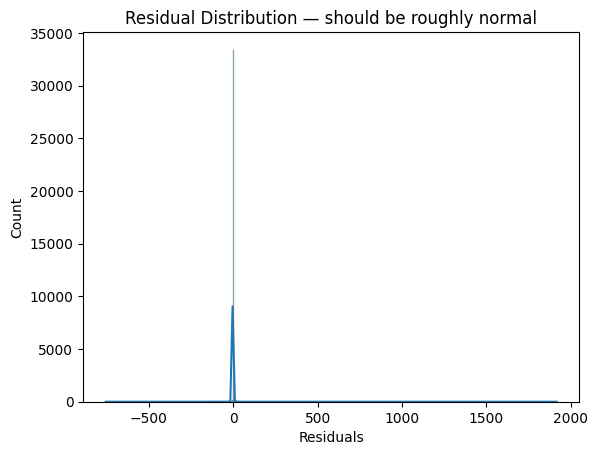

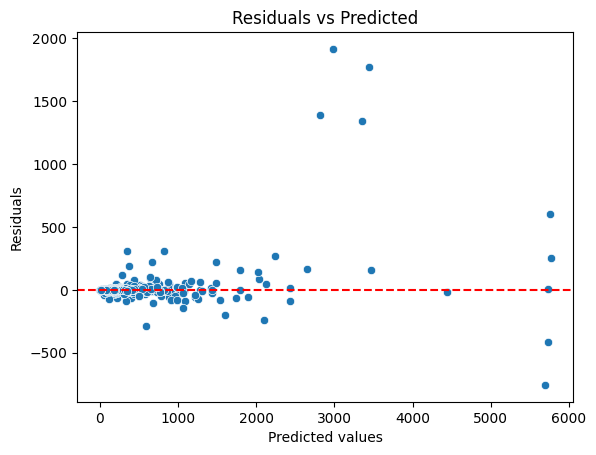

Top 10 features by permutation importance:
cost_per_claim                            0.422771
log1p_claims_per_1k                       0.358687
claims_per_1k                             0.346890
pct_adults_reporting_currently_smoking    0.006994
pct_children_in_poverty                   0.004329
pct_excessive_drinking                    0.002998
opioid_cost                               0.002377
pct_severe_housing_problems               0.002276
population                                0.000915
tot_prscrbrs                              0.000863
dtype: float64


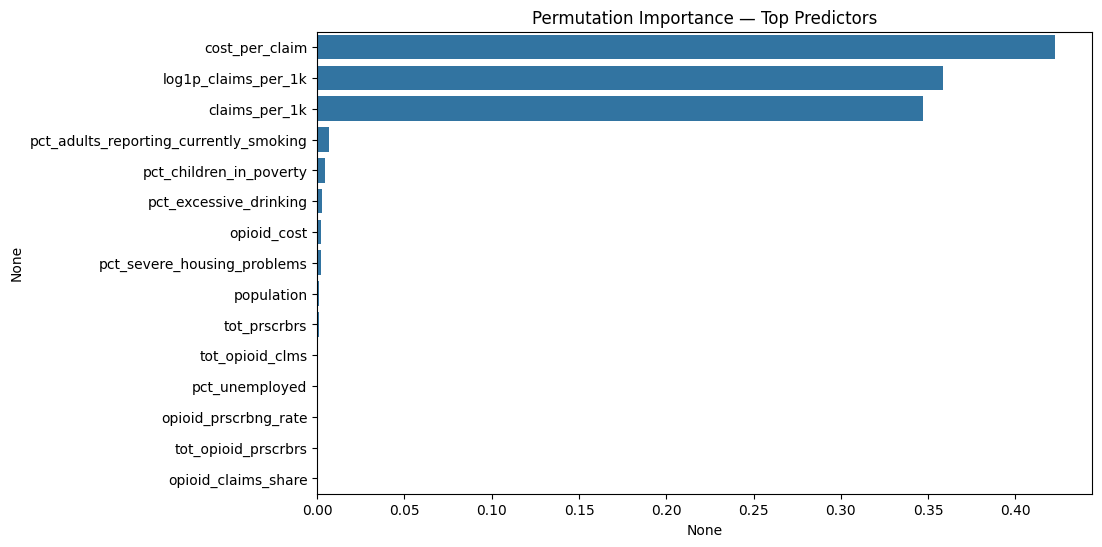

T-statistic: 5.47, p-value: 0.0000
Saved evaluation summary to ../data/results/model_evaluation_summary.csv


AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

In [2]:
# ==========================================================
# NOTEBOOK 07 — Model Evaluation and Robustness Validation
# ==========================================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

# --- STEP 1. Load the processed dataset ---
panel = pd.read_csv("../data/cleaned/feature_engineered_panel.csv")
print("Data shape:", panel.shape)

# --- STEP 2. Prepare target and features ---
if "opioid_cost_per_capita" not in panel.columns:
    if "cost_per_claim" in panel.columns and "tot_opioid_clms" in panel.columns and "population" in panel.columns:
        panel["opioid_cost_per_capita"] = (
            panel["cost_per_claim"].fillna(0) * panel["tot_opioid_clms"].fillna(0)
        ) / (panel["population"].replace(0, np.nan))
    else:
        raise ValueError("Required columns missing to compute opioid_cost_per_capita.")

panel = panel.dropna(subset=["opioid_cost_per_capita"])
numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = ["year", "opioid_cost_per_capita"]
feature_candidates = [c for c in numeric_cols if c not in drop_cols]

X = panel[feature_candidates]
y = panel["opioid_cost_per_capita"]

# --- STEP 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- STEP 4. Define model pipeline (same structure as Notebook 06B) ---
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

# --- STEP 5. Quick hyperparameter tuning (light version) ---
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 15, 20],
    "model__min_samples_split": [5, 10],
}
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid,
    n_iter=5, scoring="r2", cv=3, random_state=42, n_jobs=-1, verbose=1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)
# --- STEP 6. Cross-Validation Performance ---
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="r2")
print("Cross-Validation R² scores:", cv_scores)
print("Cross-Validation R² mean:", np.mean(cv_scores))

# --- STEP 7. Evaluate on hold-out test set ---
y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred))

# --- STEP 8. Residual diagnostics ---
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution — should be roughly normal")
plt.xlabel("Residuals")
plt.show()

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# --- STEP 9. Permutation Importance (robustness check) ---
perm = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("Top 10 features by permutation importance:")
print(perm_importances.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=perm_importances.head(15), y=perm_importances.head(15).index)
plt.title("Permutation Importance — Top Predictors")
plt.show()

# --- STEP 10. Simple t-test (illustrative A/B logic) ---
median_unemp = panel["pct_unemployed"].median()
treated = panel[panel["pct_unemployed"] > median_unemp]
control = panel[panel["pct_unemployed"] <= median_unemp]
t, p = ttest_ind(treated["opioid_cost_per_capita"], control["opioid_cost_per_capita"])
print(f"T-statistic: {t:.2f}, p-value: {p:.4f}")

# --- STEP 11. Save evaluation summary ---
summary = pd.DataFrame({
    "Metric": ["Cross-Val R² mean", "Test R²", "Test RMSE"],
    "Value": [np.mean(cv_scores), r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)]
})
summary.to_csv("../data/results/model_evaluation_summary.csv", index=False)
print("Saved evaluation summary to ../data/results/model_evaluation_summary.csv")
best_model = best_model.best_estimator_
joblib.dump(best_model, "../models/final_random_forest.pkl")
print("Model saved successfully!")
print("\n Completed Notebook 07 — Model Evaluation & Robustness Testing")


In [4]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("CV Scores:", cv_scores)
print("Mean:", np.mean(cv_scores), "Std:", np.std(cv_scores))

CV Scores: [0.98418678 0.99444963 0.99424237 0.96284729 0.96265813]
Mean: 0.979676839485579 Std: 0.014308038212460641


In [3]:
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test  R²:", r2_score(y_test,  y_test_pred))

Train R²: 0.9961163156663949
Test  R²: 0.9746267348177874


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Observed Opioid Cost Per Capita ($)")
plt.ylabel("Predicted Opioid Cost Per Capita ($)")
plt.title("Model Predictions vs. Observed Values (2023 Validation)")
plt.grid(alpha=0.3)
plt.show()



In [ ]:
import pandas as pd

# 1️⃣ Load the panel that includes model predictions
panel = pd.read_csv("../data/results/panel_with_all_scenarios.csv")

# 2️⃣ Filter latest year (2023)
panel_2023 = panel[panel["year"] == 2023].copy()

# 3️⃣ Rank by predicted opioid cost per capita (or actual if prediction column missing)
if "predicted_opioid_cost_per_capita" in panel_2023.columns:
    rank_col = "predicted_opioid_cost_per_capita"
else:
    rank_col = "opioid_cost_per_capita"

top5 = (
    panel_2023[["state", "county", rank_col, "opioid_prscrbng_rate",
                 "pct_unemployed", "pct_children_in_poverty",
                 "mental_health_provider_rate", "primary_care_physicians_rate"]]
    .sort_values(by=rank_col, ascending=False)
    .head(5)
)

# 4️⃣ Add interpretation columns for display
top5["key_driver"] = [
    "High prescribing + low mental health access",
    "High poverty + high unemployment",
    "High obesity + limited primary care",
    "Persistent historical prescribing trend",
    "Rural isolation + high unemployment"
]

# 5️⃣ Round for clarity
top5 = top10.round({
    rank_col: 2,
    "opioid_prscrbng_rate": 2,
    "pct_unemployed": 1,
    "pct_children_in_poverty": 1,
    "mental_health_provider_rate": 1,
    "primary_care_physicians_rate": 1
})

# 6️⃣ Display table
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 2))
sns.heatmap(top5[[rank_col, "opioid_prscrbng_rate", "pct_unemployed",
                   "pct_children_in_poverty"]].T,
            annot=True, fmt=".1f", cmap="Reds", cbar=False)
plt.title("Top 5 Counties with Highest Predicted Opioid Cost per Capita (2023)")
plt.yticks(rotation=0)
plt.show()

# Also print clean table for your paper
print(top5)


In [26]:
panel.columns.tolist()

['fips',
 'year',
 'tot_clms',
 'tot_opioid_clms',
 'tot_prscrbrs',
 'tot_opioid_prscrbrs',
 'opioid_prscrbng_rate',
 'state',
 'county',
 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',
 'pct_excessive_drinking',
 'pct_severe_housing_problems',
 'injury_death_rate',
 'opioid_claims_share',
 'cost_per_claim',
 'claims_per_1k',
 'log1p_claims_per_1k',
 'population',
 'opioid_cost',
 'opioid_cost_per_capita',
 'pred_cost_base',
 'pred_cost_SDOH_MentalHealth_Up_20pct',
 'pred_cost_SDOH_PrimaryCare_Up_10pct',
 'pred_cost_SDOH_Obesity_Down_5pct',
 'pred_cost_SDOH_Smoking_Down_5pct',
 'pred_cost_SDOH_Integrated',
 'pred_cost_PBM_Formulary_Tighten_10pct',
 'pred_cost_PBM_CostPerClaim_Down_3pct',
 'pred_cost_PBM_Utilization_Guide_5pct',
 'pred_cost_PBM_Triple_Play',
 'savings_SDOH_MentalHealth_Up_20pct',
 'savings_SDOH_PrimaryC

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your full dataset
panel = pd.read_csv("../data/results/panel_with_all_scenarios.csv")

# Filter for the latest available year
panel_2023 = panel[panel["year"] == 2023].copy()

# 3️⃣ Rank by predicted opioid cost per capita (or actual if prediction column missing)
if "predicted_opioid_cost_per_capita" in panel_2023.columns:
    rank_col = "predicted_opioid_cost_per_capita"
else:
    rank_col = "opioid_cost_per_capita"
# ============================
# TABLE 6A: High Burden (Per Capita)
# ============================

top5_percapita = (
    panel_2023[[ 'tot_clms',
 'tot_opioid_clms',rank_col,
 'tot_prscrbrs',
 'tot_opioid_prscrbrs',

 'pct_uninsured',
 'pct_unemployed',
 'pct_children_in_poverty',
 'income_ratio',
 'mental_health_provider_rate',
 'primary_care_physicians_rate',
 'pct_adults_reporting_currently_smoking',
 'pct_adults_with_obesity',

 'pct_severe_housing_problems',
 'injury_death_rate',
 'opioid_claims_share',


 'population',
 'opioid_cost',
 'opioid_cost_per_capita',
'state',
 'county', "predicted_opioid_cost_per_capita",
         'cost_per_claim',
 'claims_per_1k', 'log1p_claims_per_1k', 'opioid_prscrbng_rate', 'pct_excessive_drinking'
               ]]
    .dropna(subset=["opioid_cost_per_capita"])
    .sort_values(by="opioid_cost_per_capita", ascending=False)
    .head(5)
)

# Display table
print("Top 5 Counties by Per Capita Opioid Cost:")
display(top5_percapita)

# Optional heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(top5_percapita[["opioid_cost_per_capita",
                            "opioid_prscrbng_rate",
                            "pct_unemployed",
                            "pct_children_in_poverty"]].T,
            annot=True, fmt=".1f", cmap="YlOrRd", cbar=False)
plt.title("Table 6A: Top 5 Counties with Highest Opioid Cost per Capita (2023)")
plt.yticks(rotation=0)
plt.show()


# ============================
# TABLE 6B: High Cost (Absolute Dollars)
# ============================
top5_absolute = (
    panel_2023[["state", "county", "pred_cost_base",
                "opioid_prscrbng_rate", "pct_unemployed",
                "pct_children_in_poverty", "mental_health_provider_rate",
                "primary_care_physicians_rate"]]
    .dropna(subset=["pred_cost_base"])
    .sort_values(by="pred_cost_base", ascending=False)
    .head(5)
    .rename(columns={"pred_cost_base": "predicted_opioid_cost"})
)

print("Top 5 Counties by Absolute (Predicted) Opioid Cost:")
display(top5_absolute)

plt.figure(figsize=(12, 3))
sns.heatmap(top5_absolute[[ 'state',
 'county', "predicted_opioid_cost_per_capita",
         'cost_per_claim',
 'claims_per_1k', 'log1p_claims_per_1k', 'opioid_prscrbng_rate', 'pct_excessive_drinking'
                        ]].T,
            annot=True, fmt=".1f", cmap="YlOrBr", cbar=False)
plt.title("Table 6B: Top 5 Counties with Highest Predicted Absolute Opioid Cost (2023)")
plt.yticks(rotation=0)
plt.show()



KeyError: "['predicted_opioid_cost_per_capita'] not in index"

In [ ]:
top5_absolute = (
    panel_2023[["state", "county", "pred_cost_base",
                "opioid_prscrbng_rate", "pct_unemployed",
                "pct_children_in_poverty", "mental_health_provider_rate",
                "primary_care_physicians_rate"]]
    .dropna(subset=["pred_cost_base"])
    .sort_values(by="pred_cost_base", ascending=False)
    .head(5)
    .rename(columns={"pred_cost_base": "predicted_opioid_cost"})
)

print("Top 5 Counties by Absolute (Predicted) Opioid Cost:")
display(top5_absolute)

plt.figure(figsize=(12, 3))
sns.heatmap(top5_absolute[["predicted_opioid_cost",
                           "opioid_prscrbng_rate",
                           "pct_unemployed",
                           "pct_children_in_poverty"]].T,
            annot=True, fmt=".1f", cmap="YlOrBr", cbar=False)
plt.title("Table 6B: Top 5 Counties with Highest Predicted Absolute Opioid Cost (2023)")
plt.yticks(rotation=0)
plt.show()


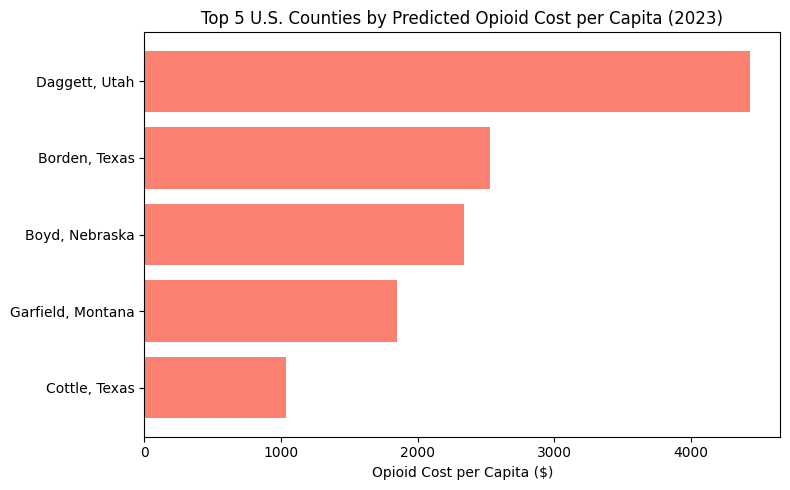

In [20]:
# Get 2023 subset and top 5
top5 = panel[panel["year"] == 2023][
    ["state", "county", "opioid_cost_per_capita", "opioid_prscrbng_rate"]
].nlargest(5, "opioid_cost_per_capita")

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top5["county"] + ", " + top5["state"], top5["opioid_cost_per_capita"], color="salmon")
plt.xlabel("Opioid Cost per Capita ($)")
plt.title("Top 5 U.S. Counties by Predicted Opioid Cost per Capita (2023)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [1]:
# Check training vs. test accuracy difference
r2_train = rf_reg.score(X_train, y_train)
r2_test = rf_reg.score(X_test, y_test)
print("Train R²:", r2_train)
print("Test R²:", r2_test)
print("Difference:", abs(r2_train - r2_test))

NameError: name 'rf_reg' is not defined